## Dataset info


Original data and info:       https://www.nature.com/articles/s41597-021-00937-4


In [1]:
# general purpose libraries
import numpy as np
import datetime as dt
import pandas as pd
import os
import warnings
import pickle
from timeit import default_timer as timer
from collections import OrderedDict
from itertools import chain
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )


In [2]:
# plots and visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as ply_go
import plotly.figure_factory as ply_ff
import plotly.colors as ply_colors 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# DSP libraries
from scipy import signal
import librosa
import librosa.display as librosa_display

In [4]:
# ML and data modelling libraries
from sklearn.preprocessing   import MinMaxScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, precision_recall_curve,confusion_matrix,precision_score, recall_score,average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [5]:
### Setup paths and directories
work_dir = '/kaggle/' 
data_dir = work_dir + "input/covid19-cough-audio-classification/"
audio_outdir = work_dir + "working/"
metadata_file = "metadata_compiled.csv"

## Import metadata and select valid audio recordings

In [6]:
metadata=pd.read_csv(data_dir+metadata_file,sep=",")
#print(metadata.columns)

# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(),c] = metadata.loc[metadata[c].notnull(),c].astype(bool) 

# remove entries where either status or age is NA
print("Metadata df entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) ),]
print("Metadata df entries after cleaning NAs: {}".format(metadata.shape[0]))



Metadata df entries before cleaning NAs: 27550
Metadata df entries after cleaning NAs: 15218


### Define different classes based on combination of age and cough detection score

cough_detected is a score [0, 1] produced by a ML run by the authors. Values closer to 1 indicate a more likely presence of an actual cough sound in the recording. Values close to zero inidcate that the audio recording is likely to be spurious and not contain an actual cough. 

In [7]:
metadata['audio_class'] = 'X' # default, we should have none by the end of this classification process
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['age']>=60) ,'audio_class'] = 'A'
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['age']>=40) & (metadata['age']<60) ,'audio_class'] = 'B'
metadata.loc[ (metadata['cough_detected'] >= 0.80) & (metadata['age']< 40) ,'audio_class'] = 'C'
metadata.loc[ (metadata['cough_detected'] < 0.80) & (metadata['age']>=60) ,'audio_class'] = 'D'
metadata.loc[ (metadata['cough_detected'] < 0.80) & (metadata['age']>=40) & (metadata['age']<60) ,'audio_class'] = 'E'
metadata.loc[ (metadata['cough_detected'] < 0.80) & (metadata['age']< 40) ,'audio_class'] = 'F'

print("Entries subdivided in classes. Printing the number of entries for each class:")
print(metadata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

print("\n\n\nSplitting count by class and status:")
print(metadata[['audio_class','status','uuid']].groupby(['audio_class','status']).count().rename(columns={'uuid':'N_entries'}) )


Entries subdivided in classes. Printing the number of entries for each class:
             N_entries
audio_class           
A                  686
B                 3261
C                 6344
D                  511
E                 1523
F                 2893



Splitting count by class and status:
                         N_entries
audio_class status                
A           COVID-19            33
            healthy            600
            symptomatic         53
B           COVID-19           158
            healthy           2561
            symptomatic        542
C           COVID-19           417
            healthy           4744
            symptomatic       1183
D           COVID-19            26
            healthy            431
            symptomatic         54
E           COVID-19           110
            healthy           1193
            symptomatic        220
F           COVID-19           221
            healthy           2203
            symptomatic        46

## Train a COVID identification model

For each audio_class, train a separate model that labels the status based on key metadata, as well as audio properties of the recording.

### Helper functions

In [8]:

def import_raw_audio(filename,indir, sr=None ):
    y, sr = librosa.load(indir+filename, sr=sr, mono=True)
    duration = y.shape[0]/sr #in seconds
    mu_t = y.mean()
    min_t = y.min()
    max_t = y.max()
    f_token = np.array([filename[:-4]]).reshape(1, -1)
    tokens = np.array([sr, duration, mu_t, max_t, min_t]).reshape(1,-1)
    audio_df = pd.DataFrame(data= np.hstack((f_token, tokens)),
                         columns=['AUDIO_FILE', 'SAMPLING_RATE','DURATION', 'MEAN_SIG', 'MAX_SIG', 'MIN_SIG' ],
                         )
    audio_df['SAMPLING_RATE'] = audio_df['SAMPLING_RATE'].astype(float).astype(int)#weird conversion from string to int 
    for i in ['DURATION', 'MEAN_SIG', 'MAX_SIG', 'MIN_SIG' ]:
        audio_df[i] = audio_df[i].astype(float)
    
    return audio_df, y, sr
    
def zero_padding(y, sr, target_duration):
    """do zero-padding to get audio files all of the same duration; 
       this will allow us to have spectrograms all of the same size"""
    target_len = target_duration * sr
    if y.shape[0] > target_len:
        y = y[0:target_len]
    elif y.shape[0] < target_len:
        n_pads = target_len - y.shape[0] 
        y = np.append(y, np.repeat(0,n_pads)  )
    else:
        pass
    return y


def calc_stft_power_spectrum(stft, sr, n_fft):
    amplitudes = np.abs(stft)**2
    frequencies = librosa.fft_frequencies(sr, n_fft)
    psx = amplitudes.mean(axis=-1)
    return frequencies, np.sqrt(psx)


def calc_power_spectrum_welch(y, sr, n_fft):
    f, psx = signal.welch(y, sr, window='hann',nfft=n_fft, noverlap=0,axis=-1, scaling='spectrum')
    return f, np.sqrt(psx)

@staticmethod
def calc_spectral_features(y, sr, n_fft = 512, win_length = None, win_overlap=0.0, n_mfcc=None, rec_width=0):
    
    ### Calculate spectrograms:
    ###   -) Short-time Fourier transform (STFT) for the power spectrum
    ###   -) Mel-frequency cepstral coefficients (MFCC)
    ###
    ### win_overlap: float, [0.0, 1.0] ; if 0.0, windows will be NOT overlapping; 0.9999 means almost completely overlapping windows
    ### rec_width: float, unused
    ### 
    ### Output:
    ###    stft: numpy.ndarray of dimension [n_fft/2, duration*my_sampling_rate/n_fft]; 
    ###          the n_fft/2 rows represent the frequencies of the Fast Fourier Transform in time domain;
    ###          the columns are the time windows in which the raw signal has been subdivided for the FFT.
    ###          The output values are complex numbers representing the amplitude of the sine and cosine
    ###          at that specific frequency for that specific signal window
    ###
    ###   mfcc: numpy.array of dimensions [n_mfcc, duration*my_sampling_rate/n_fft];
    ###         the n_mfcc rows indicate the different mel frequency bands;
    ###         the columns are the time windows in which the raw signal has been subdivided for the FFT
    ###         that is then mapped to the mel-frequncy bins.
    ###
    
    if win_length is None:
        win_length = n_fft
    
    if n_mfcc is None:
        n_mfcc = n_fft
    
    assert (win_overlap>=0)&(win_overlap<1.0), "Invalid value of win_overlap {} - it must be in range [0.0, 1.0) ".format(win_overlap)
    hop_length = int(win_length*(1.0-win_overlap))
    
    #   stft_db = librosa.amplitude_to_db(  np.abs(librosa.stft(t, n_fft=n_fft, 
    #                                                              hop_length=hop_length, win_length=win_length )))
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length ) 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, dct_type=2)
    
    return stft,mfcc


def stack_rows_with_pad(list_of_arrays):
    f1 = lambda x: x.shape[1]
    max_dim = max(list(map(f1,list_of_arrays)) )
    padded_arrays = [ np.append(m, np.full([ m.shape[0],max_dim-m.shape[1] ],np.nan), axis=1 ) for m in list_of_arrays]
    return np.concatenate(padded_arrays, axis=0)


def calc_spectral_properties_welch(y, sr, n_fft, time_window_ms, freq_bins):
    #######
    ### Computes a whole bunch of spectral properties, after the reference (see section III.A)
    ### https://myresearchspace.uws.ac.uk/ws/files/10993506/2018_12_15_Monge_Alvarez_et_al_Cough.pdf
    ###
    ### It splits the audio signal in smaller chunks. For each chunk computes the Power Spectrum Density
    ### using the Welch method. It then averages the power for user-defined frequency bands.
    ### At that point, we have many subsegments of the audio, k, and many average PSD, j
    ### The spectral properties are calculated averaging and summing over k.
    ### Output is a dictionary with various spectral properties, each one replicated j times 
    ### (as many as the frequency bands).
    ###
    
    #sanity checks
    assert len(freq_bins)>1,"Error, input freq_bins must be a list with the boundaries of the frequency bins"
    
    
    #define how many ms is long each sample of the audio signal and how many values go in each subsegment
    n_samples_tot = len(y)
    if( time_window_ms is None ):
        time_window_ms = 1000*n_samples_tot/sr
    chunk_length = min(n_samples_tot, round(time_window_ms*sr/1000) )# how many audio samples fit in time_window_ms
    n_chunks = int(np.ceil(n_samples_tot / chunk_length))
    n_freq_bins = len(freq_bins)-1
    out_all_freq = np.empty((n_freq_bins,0),float)
    out_all_psx = np.empty((n_freq_bins,0),float)
    for k in range(0,n_chunks,1):
        tmin = k*chunk_length
        tmax = min((k+1)*chunk_length, n_samples_tot)
        tmp_segment = y[tmin:tmax]
        freqs_welch, psx_welch = calc_power_spectrum_welch(tmp_segment,sr, n_fft)
        chunk_freq = np.empty((1,0),float)
        chunk_psx = np.empty((1,0),float)
    
        for j in range(0, n_freq_bins,1):
            freqmin = freq_bins[j]
            freqmax = freq_bins[j+1]
            freq_mask = (freqs_welch>=freqmin)&(freqs_welch<freqmax)
            selfreqs = freqs_welch[freq_mask]
            selpsx = psx_welch[freq_mask]
            if(j==0):
                chunk_freq = selfreqs.reshape(1,-1)
                chunk_psx  = selpsx.reshape(1,-1)
            else:
                chunk_freq = stack_rows_with_pad([chunk_freq,selfreqs.reshape(1,-1)])  
                chunk_psx = stack_rows_with_pad([chunk_psx,selpsx.reshape(1,-1)])  
        ### end for loop on j
        
        # append horizontally (row-wise) different frames
        out_all_freq = np.append(out_all_freq,chunk_freq, axis=1)
        out_all_psx = np.append(out_all_psx,chunk_psx, axis=1)
    ####end for loop on k   
    
    
    #Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=chunk_length, hop_length=chunk_length+1)
    
    # spectral centroid
    psx_sum = np.nansum(out_all_psx, axis=1)
    spec_centroid = (np.nansum(out_all_freq*out_all_psx, axis=1)/ psx_sum).reshape(-1,1)
        
    #spectral bandwidth
    spec_bw = np.nansum( ((out_all_freq-spec_centroid)**2)*out_all_psx,axis=1)/psx_sum

    #spectral crest factor
    psx_25 = np.nanquantile(out_all_psx,.25, axis=1)
    psx_50 =np.nanquantile(out_all_psx,.50, axis=1)
    psx_75 = np.nanquantile(out_all_psx,.75, axis=1)  
    psx_max = np.nanmax(out_all_psx, axis=1)
    spec_crest = (psx_max-psx_50) / (psx_75 - psx_25)
    
    # spectral standard deviation
    spec_sd = np.nanstd( out_all_psx,axis=1)
    
    #spectral skewness
    n_entries = np.array([ len(row[~np.isnan(row)]) for row in out_all_psx])#.reshape(-1,)
    skew_factors = [ e*np.sqrt(e-1)/(e-2) for e in n_entries]
    spec_mean = np.nanmean(out_all_psx,axis=1).reshape(-1,1)
    spec_skew = skew_factors*np.nansum((out_all_psx-spec_mean)**3, axis=1)  / spec_sd**3
    
    return zcr, spec_centroid.reshape(1,-1), spec_bw.reshape(1,-1), spec_crest.reshape(1,-1), spec_mean.reshape(1,-1),spec_sd.reshape(1,-1),spec_skew.reshape(1,-1)
    
 

### DSR parameters

In [9]:
my_sampling_rate = int(4096*2)  # Sampling rate, how frequently we want to take a value of the audio curve.
                                 # the max frequency in the STFT will be (approximately) half of this
                               
my_n_fft = 512 # number of frequency bins to be calculated in the STFT; 
               # if my_window_size is None, this drives also the time-sampling window
    
my_n_mfcc = 26 # number of mel-frequencies used for the MFCC calculation. The original article used
               # a number of 13 MFCC frequencies, I am trying to add some extra info   
    
my_window_size = None # should not be greater than n_fft
target_duration = 10 # seconds; shorter audios will be zero padded; longer audios will be cut;
                     # obtained from an earlier dry run over all data and charting the distribution 
                     # of duration of the raw sound samples; 10 sec corresponds to the 97th percentile and 
                     # represent a significant improvement in terms of computing time (x5 faster) 
                     # respect to more conservative choices like 70 seconds (99th percentile)


iclass = "A"   # the class of audio records to be processesed (see previous cells)

### these are the frequency bins used to compute short-term features as per the original article (used as inputs to the cough detection classifier).
### Note that the code here will compute features for all bins but in the original paper they use only non-contiguous values.
### For example, we keep the bin [0, 200] Hz but not the [200, 300] Hz; the lowest bin used inthe rest of htis analysis will be [0, 200] Hz,
### the highest one will be [3800, 3900] Hz
my_psd_freqs = [0.0, 200.0, 300.0, 425, 500.0, 650.0, 950.0, 1150.0, 1400.0, 1800.0, 2300.0, 2400.0, 2850.0, 2950.0, 3800.0, 3900, 4000]
psd_feature_names =['SPEC_CENTROID', 'SPEC_WIDTH', 'SPEC_CREST', 'SPEC_MEAN', 'SPEC_SD', 'SPEC_SKEW']


mfcc_feature_names = [ "MFCC_MEAN_{:02}".format(i) for i in range(0,my_n_mfcc,1)]
mfcc_feature_names = mfcc_feature_names + [ "MFCC_SD_{:02}".format(i) for i in range(0,my_n_mfcc,1)]


### DSR loop over all audio files

The output of this loop is a big pandas dataframe with as many rows as audio files and a series of audio features  in the columns. The column list includes also the audio UUID and the sample label (the "status" column in the metadata file)

In [10]:
def prepare_data(input_data, audio_datadir, sr, target_duration, 
                 n_fft, n_mfcc, fft_window_size, psd_freq_bins,
                 mfcc_feature_names, psd_feature_names, 
                 max_audio_samples=None, print_every_n=10):
    ######################################################
    ###
    ### Prepares a dataframe with a collection of properties and sound features 
    ### that can be readily used later in a ML classification process
    ### 
    ### input_data: pandas data.frame; an extract of the metadata file present in the original dataset
    ###
    ### audio_datadir: string; the path to the diretory where the audio files are stored
    ###
    ### sr: int; sampling rate
    ###
    ### target_duration: int; final length of audio sample, in seconds. All audio files will be formatted 
    ###                  to this duration; longer audios will be cut; shorter audios will be padded with zeros
    ###
    ### n_fft: int; number of frequency bins to be considered in the Fast Fourier Transform
    ###
    ### n_mfcc: int; number of Mel-freuqencies to be used when computing the MFCC
    ###
    ### max_audio_samples: int; maximum number of audio files to be processed. If None, all available UUIDs  
    ###                    will be processed; otherwise, only the first max_audio_sample UUID will be considered
    ###
    ###
    ### Output: The output of this loop is a big pandas dataframe with as many rows as audio files 
    ###         and as many columns as a series of audio features. 
    ###         The column list includes also the audio UUID and the sample label (the "status" column in the metadata file).
    ###
    ######################################################
    
    # get the full list of uuid to be processed
    all_uuids = input_data['uuid'].values
    if max_audio_samples is not None:
        all_uuids[0:max_audio_samples]


    # empty pandas df where to store all features for all UUIDs
    all_data = pd.DataFrame()

    # init  timer and df containig some metadata of the audio files
    skipped_uuids = []
    audio_metadata = pd.DataFrame()
    t_start = timer()


    for idx, uuid in enumerate(all_uuids):
              
        tmp_audiofilename = uuid+".webm"
        if not os.path.exists(audio_datadir+tmp_audiofilename):
            # try to look for a .ogg file
            tmp_audiofilename = uuid+".ogg"
            if not os.path.exists(audio_datadir+tmp_audiofilename):
                warn("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(uuid))
                continue

        if idx % print_every_n ==0:
            print("Processing file #{}: {}".format(idx,tmp_audiofilename))

        try:
            tmp_df, tmp_audio, sr = import_raw_audio(tmp_audiofilename, indir=audio_datadir, sr=sr)
        except FileNotFoundError as e_fnf:
            print("Could not find audio file {}.\n\n\n".format(tmp_audiofilename))
            skipped_uuids = skipped_uuids + [uuid]
            continue #move to next file
        except Exception as e:
            print("Some other exception occurred")
            raise e #rethrow exception

        tmp_audio = zero_padding(tmp_audio, sr=sr, target_duration=target_duration) 
        tmp_df['UUID'] = uuid
        audio_metadata = audio_metadata.append(tmp_df)


        stft , mfcc = calc_spectral_features(tmp_audio, sr, n_fft=n_fft,n_mfcc=n_mfcc, win_length=fft_window_size, win_overlap=0.0)

        ### extract mean and std dev for each mel-frequency in the mfcc
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_sd = np.std(mfcc,axis=1)
        mfcc_features = np.append(mfcc_mean,mfcc_sd,axis=0)
        mfcc_feat_dict = {name:val for name,val in zip(mfcc_feature_names,mfcc_features)}

        ### Power Spectrum Density based short-term features
        zcr,sc,sb,scf,ssmean, ssd, ssk = calc_spectral_properties_welch(tmp_audio,sr, my_n_fft,None, psd_freq_bins)
        # consider only every second bin to reduce features; following original article freq bins
        psd_features = np.array([ (x0, x1, x2, x3,x4,x5) for i, (x0, x1, x2, x3,x4,x5) in enumerate(zip(*sc, *sb,*scf,*ssmean, *ssd, *ssk)) if i%2==0]).transpose() 

        #now extract each element of the PSD feature (correspondignto a unique combination of spectral feature and freq bin)
        n_freq_bins = psd_features.shape[1]
        psd_features = psd_features.ravel()
        psd_feature_names_expanded = [ [ "{f}_{b:02}".format(f=f,b=b) for b in range(0,n_freq_bins,1) ] for f in psd_feature_names]
        psd_feature_names_expanded = list(chain.from_iterable(psd_feature_names_expanded))
        assert len(zcr)==1, "Zero-Crossing Rate vector has length different from 1: {}".format(len(zcr))
        assert len(psd_feature_names_expanded)==len(psd_features), "Mismatch between number of spectral features ({nf}) and vector with their names ({nn})".format(nf=len(psd_features) , nn=len(psd_feature_names_expanded)) 
        psd_feat_dict = { name:val for name,val in zip(psd_feature_names_expanded,psd_features)}
        psd_feat_dict['ZCR'] = zcr[0,0]

        # store all features in a pandas dataframe
        tmp_df = input_data.loc[ tmp_metadata['uuid']==uuid, ['uuid','audio_class','cough_detected','SNR','age','gender','respiratory_condition','fever_muscle_pain','status'] ]
        tmp_df.columns = [c.upper() for c in tmp_df.columns]
        tmp_dict = tmp_df.to_dict(orient='records')
        tmp_dict = OrderedDict(tmp_dict[0] ) 
        tmp_dict.update(mfcc_feat_dict)
        tmp_dict.update( psd_feat_dict)
        all_data = all_data.append(pd.DataFrame(tmp_dict,index=[idx]))#, ignore_index=True)

    ### end for loop over raw audio files
    print("\n{} files processed in {:.1f} seconds\n".format(idx+1, timer()-t_start ))
    return all_data,audio_metadata
####
#### end prepare_data
#### 

### Balance classes in the dataframe

The dataset is imbalanced (about 10% of entries are labelled as 'COVID') but at least we have quite a number of records. We rebalance the three STATUS classes in the dataset by reducing the number of the overwhelming 'healthy' class.

In [11]:
# the following looks more complicated than needed because I want first to keep all entries of the smallest group
# then upsample the difference between that and the target number n_resampling. No pandas function is allowing me to do this.
def sample_df_balanced(df, group_col, n, random=42):
    assert isinstance(group_col,str), "Input group_col must be a plain string with the column name: {}".format(type(group_col))
    df['N'] = np.zeros(len(df[group_col]))
    df_count = df[[group_col,'N']].groupby([group_col]).count().reset_index()     
    out_df = pd.DataFrame()
    for igroup in df[group_col].unique():

        n_orig = df_count.loc[df_count[group_col]==igroup,'N'].values[0]
        if n_orig < n: # need to upsample
            delta = max(n - n_orig, 0)
            tmp_df = df.loc[df[group_col]==igroup, ]
            delta_df = tmp_df.sample(n=delta,random_state=random,replace=False)
            out_df = pd.concat([out_df,tmp_df,delta_df])
        else: #downsample
            tmp_df = df.loc[df[group_col]==igroup, ].sample(n=n,random_state=random,replace=False)
            out_df = pd.concat([out_df,tmp_df])
    ### end for loop over groups
    return out_df.drop('N',axis=1,inplace=False)
### end sample_df_balanced

   

In [12]:
# filter UUID, keeping only those in the desired class
tmp_metadata = metadata.loc[metadata['audio_class']==iclass,]

# remove entries where the SNR is low (hence the cough audio sound is of poor quality)
# This cut should be optimised, at this stage I just decide to cut off the worst 10%
tmp_metadata = tmp_metadata.loc[tmp_metadata['SNR']>=tmp_metadata['SNR'].quantile(0.10),]


In [13]:
print("Before resampling, count of entries by STATUS class in the full data.frame:")
tmp_metadata_count = tmp_metadata[['uuid','status']].groupby(['status']).count()
print(tmp_metadata_count)
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))

# every group will have a number of entries equal to the number of records 
# in the smallest group, rounded to the closest ten above
n_resampling = int(np.ceil(tmp_metadata_count['uuid'].min()/10)*10)

  
    
tmp_metadata = sample_df_balanced(tmp_metadata, 'status', n_resampling) 
print("\nAfter resampling, count of entries by STATUS class in the full data.frame:")
print(tmp_metadata[['uuid','status']].groupby(['status']).count())
print(len(tmp_metadata.loc[tmp_metadata['status']=='COVID-19', 'uuid'].unique()))


Before resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19       32
healthy       536
symptomatic    49
32

After resampling, count of entries by STATUS class in the full data.frame:
             uuid
status           
COVID-19       40
healthy        40
symptomatic    40
32


OK, now we do the proper audio signal processing over all files in the same class.

In [ ]:

all_data, all_audio_metadata = prepare_data(input_data=tmp_metadata, audio_datadir=data_dir, sr=my_sampling_rate, 
                                            target_duration=target_duration, n_fft=my_n_fft, n_mfcc=my_n_mfcc, 
                                            fft_window_size=my_window_size, psd_freq_bins=my_psd_freqs,
                                            mfcc_feature_names=mfcc_feature_names, psd_feature_names=psd_feature_names,
                                            max_audio_samples=None, print_every_n=20) 

all_audio_metadata = all_audio_metadata.drop_duplicates(subset='UUID', keep='first') # this avoids spurious duplicates at the following merge

print("Merging dataframe with audio features and df with audio metadata")
all_data = pd.merge(all_data,all_audio_metadata,on=['UUID'],how='inner')
all_data.drop(['AUDIO_FILE'],axis=1,inplace=True)

print("Shape of full dataframe with features and labels: {}".format(all_data.shape))
all_data.head(10)



#### Save dataframe for faster pricessing later 

In [15]:
out_data_filename = audio_outdir+"/cough-classification-data_Class{}.pkl".format(iclass )
pd.to_pickle(all_data, out_data_filename)  # save df to file

### one more check that all covid status are balanced
all_data[['UUID','STATUS']].groupby(['STATUS']).count().rename(columns={'UUID':'N_UUID'})


,N_UUID
STATUS,
COVID-19,40
healthy,40
symptomatic,40


### Visualise sound and spectrograms for a given UUID

/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(26, 161)


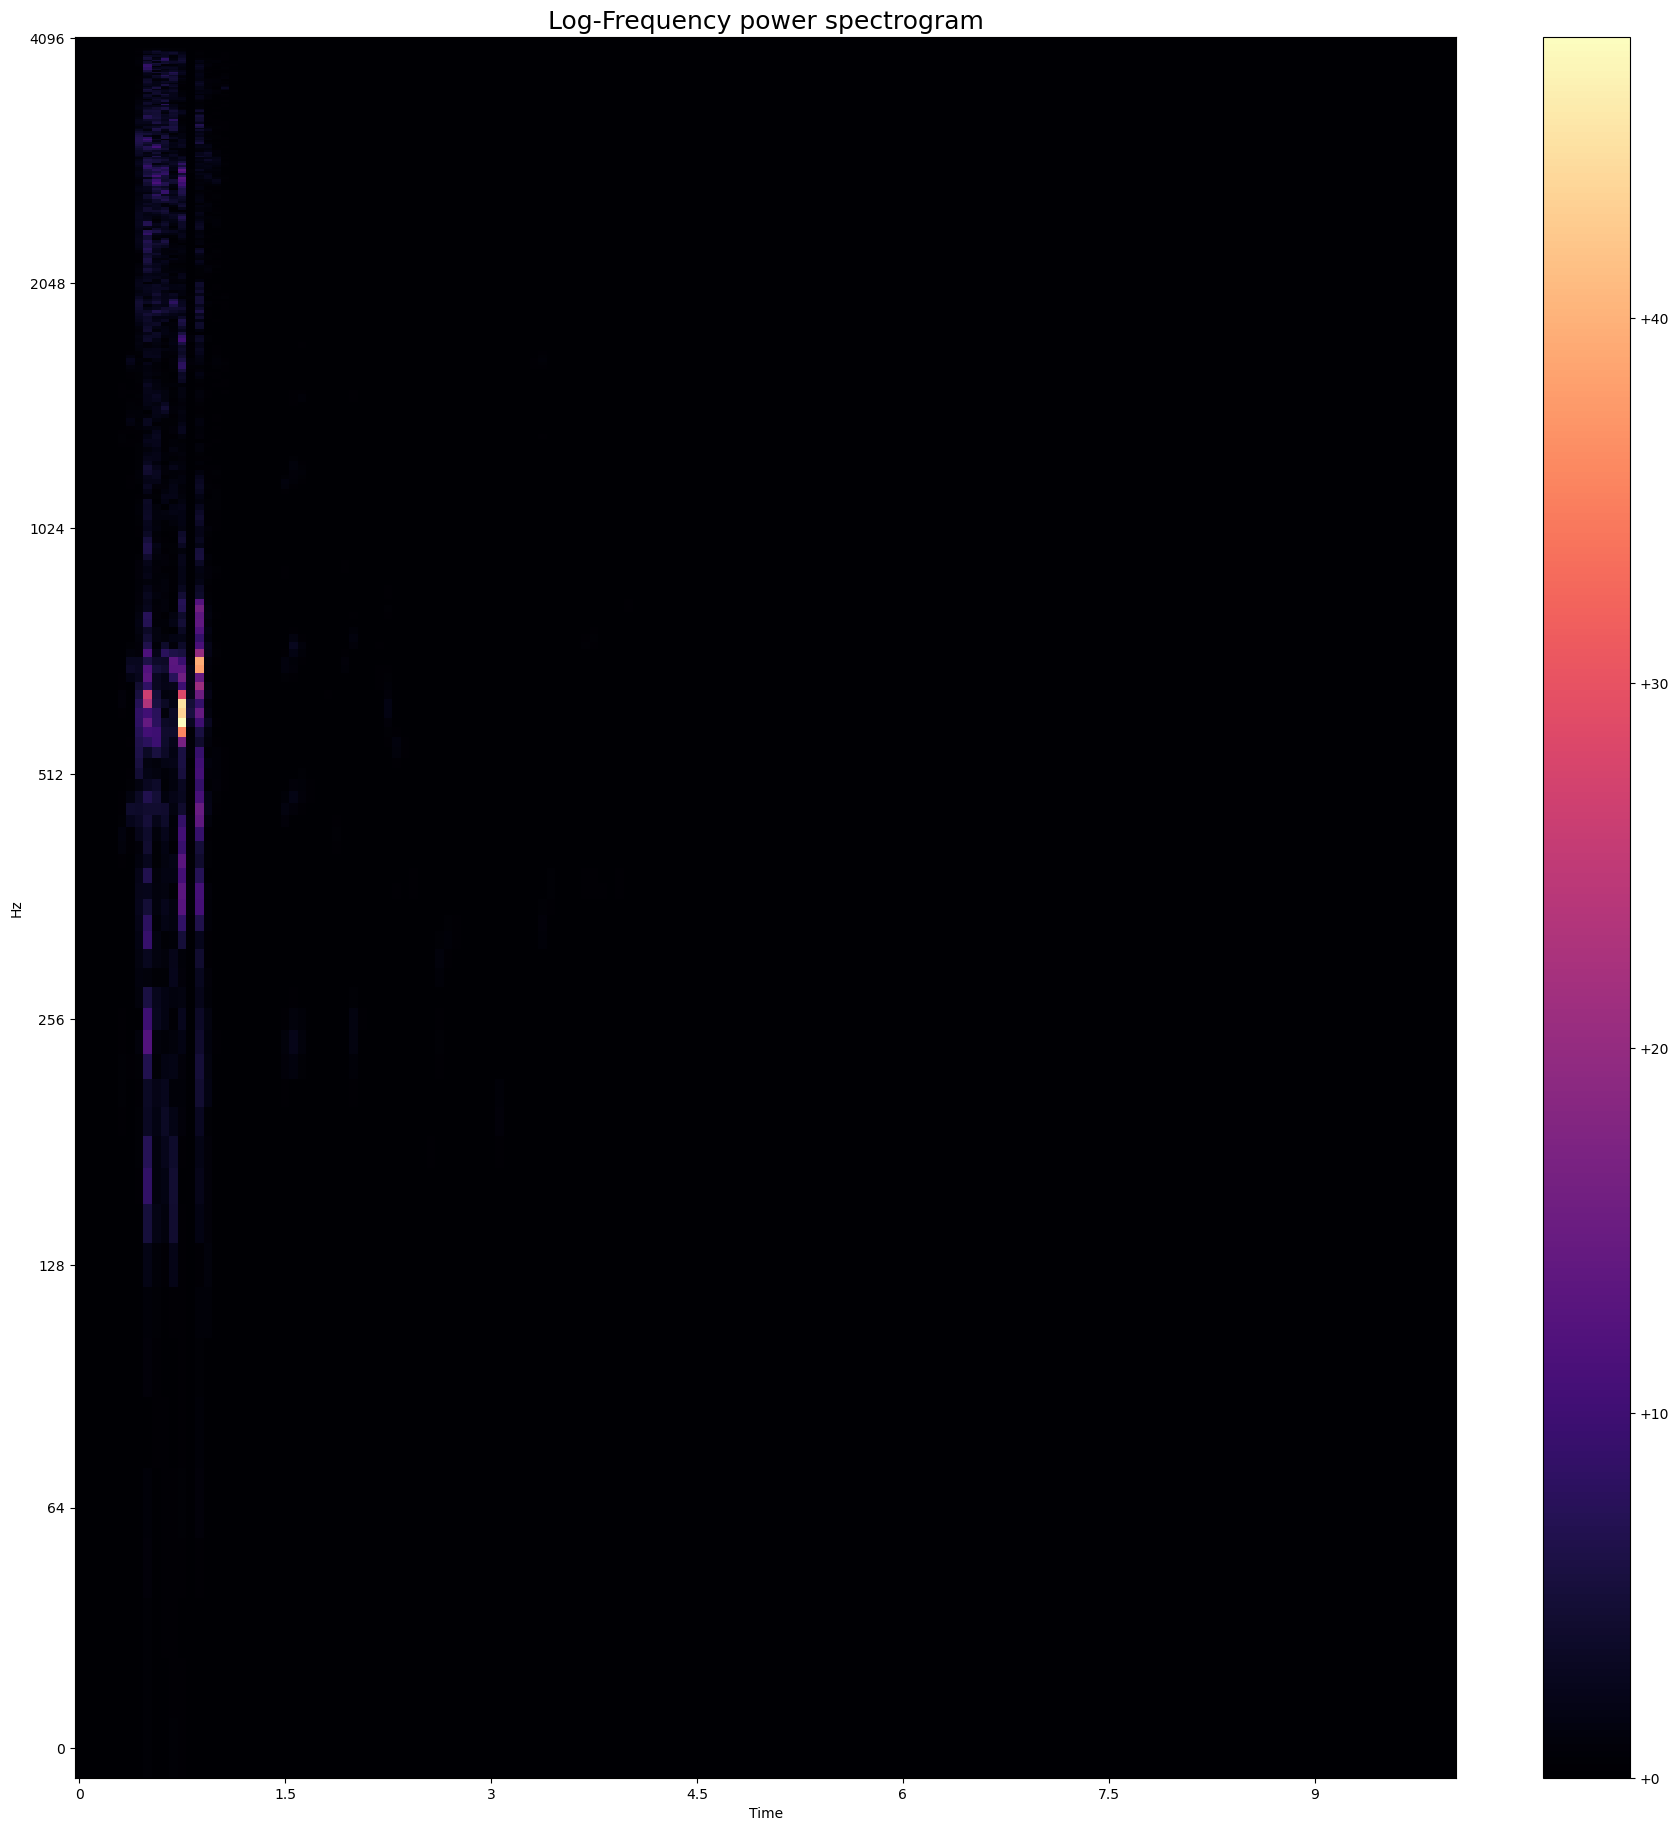

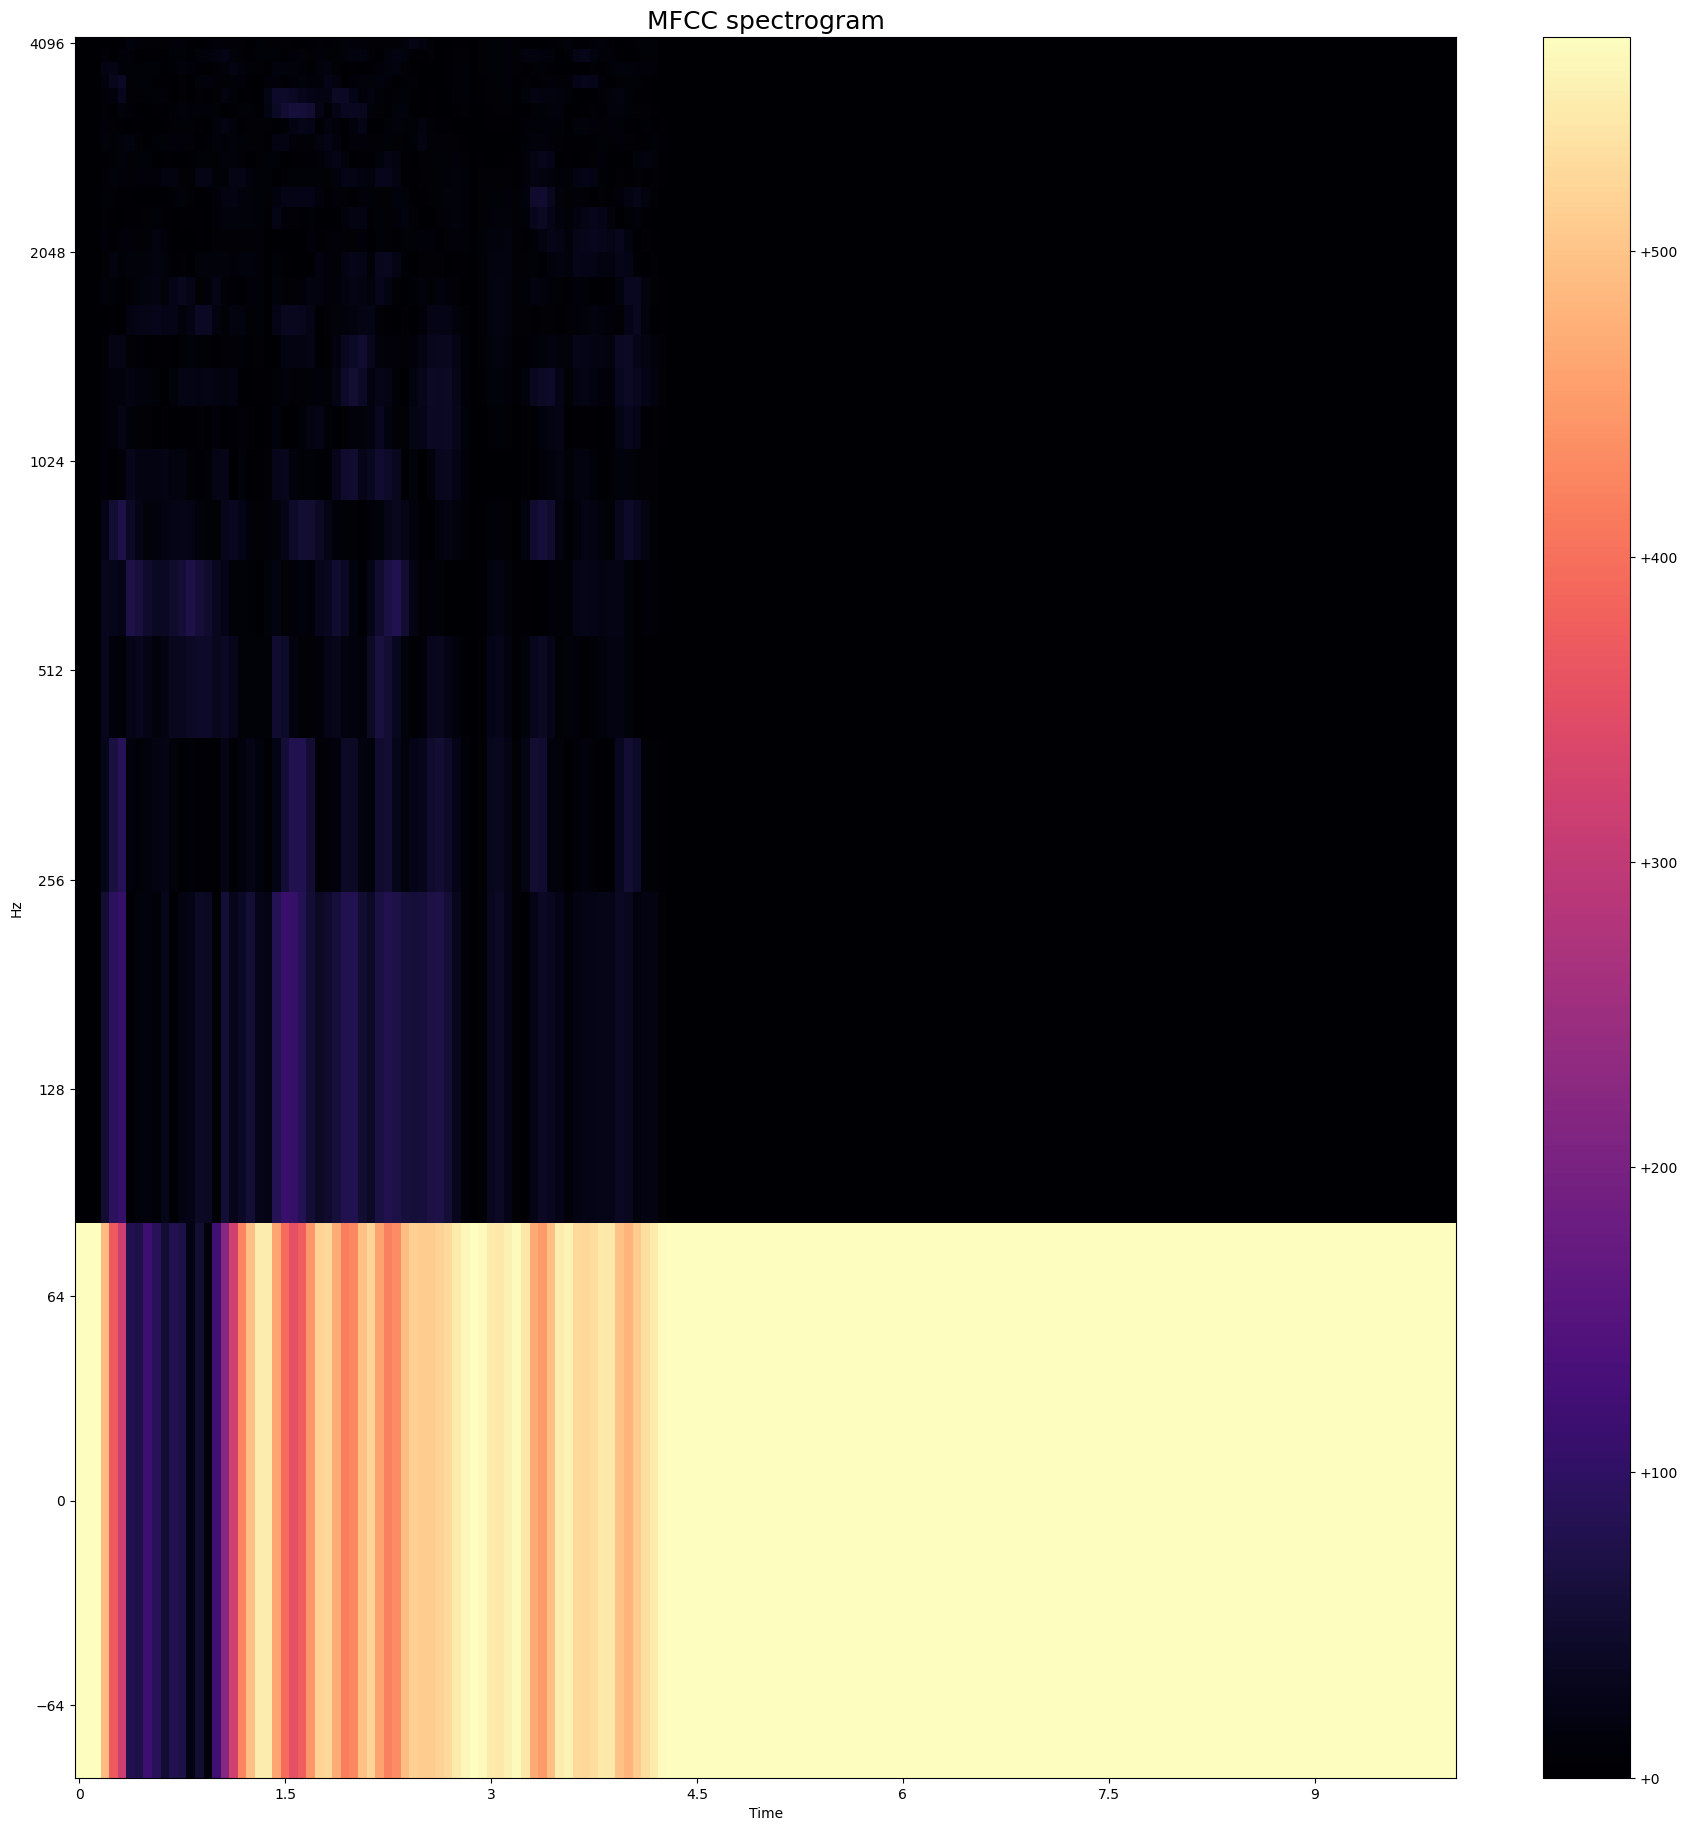

In [16]:
all_uuids = all_data['UUID'].unique()
uuid_tmp = all_uuids[10] #"0379c586-c500-483c-83a6-95b63afe6931"#all_uuids[10]
tmp_audiofilename = uuid_tmp+".webm"
        
tmp_df, tmp_audio, sr = import_raw_audio(tmp_audiofilename, indir=data_dir, sr=my_sampling_rate)
tmp_audiofilename = uuid_tmp+".webm"
tmp_audio = zero_padding(tmp_audio, sr=sr, target_duration=target_duration)                                                         
stft , mfcc = calc_spectral_features(tmp_audio, sr, n_fft=my_n_fft,n_mfcc=my_n_mfcc,win_overlap=0.0)
freqs_welch, psx_welch = calc_power_spectrum_welch(tmp_audio,sr, my_n_fft)
        
print(mfcc.shape)
time_stamps = np.arange(0,target_duration, 1/my_sampling_rate)

# plot raw signal
line_data = ply_go.Scatter(x=time_stamps, 
                           y=tmp_audio,
                           name="Audio signal", showlegend=False)
fig = ply_go.Figure(data=[line_data])
fig.update_layout(title={'text': "Raw audio (UUID:{})".format(uuid_tmp)}, 
                  xaxis={"title":{"text":"Time [s]"}}, yaxis={"title":{"text":"Amplitude"}})
fig.show()

# plot STFT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,18)) 
fig.tight_layout()
img0 = librosa.display.specshow(np.abs(stft), sr=sr, y_axis='log', x_axis='time', ax=ax)

ax.set_title('Log-Frequency power spectrogram', size=18)
fig.colorbar(img0, format="%+2.f")
fig.show()


# plot MFCC
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,18)) 
fig.tight_layout()
img0 = librosa.display.specshow(np.abs(mfcc), sr=sr, y_axis='log', x_axis='time', ax=ax)

ax.set_title('MFCC spectrogram', size=18)
fig.colorbar(img0, format="%+2.f")
fig.show()

# plot power spectrum
line_data = ply_go.Scatter(x=freqs_welch,
                           y=psx_welch,
                           name="Power Spectrum density", showlegend=False)
fig = ply_go.Figure(data=[line_data])#, layout=my_layout)
fig.update_layout(title={'text': "Power Spectrum Density (UUID:{})".format(uuid_tmp)}, 
                  xaxis={"title":{"text":"Frequency [Hz]"}}, yaxis={"title":{"text":"Average Power"}})
fig.show()




### Split train-test

Use argument 'stratify' to preserve small classes, due to imbalance in dataset

In [17]:
sampled_data = all_data.copy()
all_uuids = sampled_data['UUID'].values

max_freq_features = 99
train_features = (['RESPIRATORY_CONDITION', 'FEVER_MUSCLE_PAIN','MEAN_SIG','MAX_SIG','MIN_SIG','ZCR']+
                  [f2 for f2 in [ f1 for f1 in sampled_data.columns.values  if f1.startswith('MFCC_')] if int(f2[-2:])<max_freq_features]+
                  [f2 for f2 in [ f1 for f1 in sampled_data.columns.values  if f1.startswith('SPEC_')] if int(f2[-2:])<max_freq_features])

y_label = 'STATUS'

print("Number of training X features: {}".format(len(train_features)) )
X_train, X_test, y_train, y_test, uuid_train, uuid_test = train_test_split(sampled_data[train_features].values, sampled_data[[y_label]].values, all_uuids,
                                                                            test_size=0.3,random_state=612, stratify=sampled_data[y_label])
print("Shapes of train X and y datasets: X->{}    y->{}".format(X_train.shape ,y_train.shape))
print("Shapes of test  X and y datasets: X->{}    y->{}".format(X_test.shape, y_test.shape))


print("\n\nTRAIN DATASET - Count of entries by STATUS:\nhealthy={} \tsymptomatic={} \tcovid={}\n\n".format(y_train[y_train=="healthy"].shape[0], y_train[y_train=="symptomatic"].shape[0], y_train[y_train=="COVID-19"].shape[0]))

Number of training X features: 106
Shapes of train X and y datasets: X->(84, 106)    y->(84, 1)
Shapes of test  X and y datasets: X->(36, 106)    y->(36, 1)


TRAIN DATASET - Count of entries by STATUS:
healthy=28 	symptomatic=28 	covid=28




### Normalise datasets

In order to avoid data leakage, we fit the scaler using only the training set. We also encode the target labels, XGBoost likes it better that way.

In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

labenc = LabelEncoder()
y_train_enc = labenc.fit_transform(y_train.ravel())
y_enc_labels = labenc.classes_
print(y_enc_labels)
y_test_enc = labenc.transform(y_test.ravel())

['COVID-19' 'healthy' 'symptomatic']


### Helper functions used to plot and evaluate model accuracy

In [19]:
def roc_df(ytrue, ypred):   
    falseposrate, trueposrate, thresholds = metrics.roc_curve(ytrue, ypred)
    roc_df = pd.DataFrame()
    roc_df['FalsePosRate'] = falseposrate
    roc_df['TruePosRate'] = trueposrate
    roc_df['Thresholds'] = thresholds
    return roc_df

def prc_df(ytrue, ypred):   
    precision, recall, thresholds = metrics.precision_recall_curve(ytrue, ypred)
    prc_df = pd.DataFrame()
    prc_df['Precision'] = precision[:-1]
    prc_df['Recall'] = recall[:-1]
    prc_df['Thresholds'] = thresholds
    return prc_df

def plot_prc(recall, precision, ax,
             prc_score=None, xrange=[-0.05,1.05],yrange=[-0.05,1.05]):
    
    if prc_score is not None:
        prc_label='PRC Avg Score = {:.4}'.format(prc_score)
    else:
        prc_label=None
    ax.plot(recall,precision,  'b', label=prc_label)
    ax.plot([0,1],[1,0],'r--')
    ax.set_title('Precision-Recall curve', fontsize=28)
    ax.set_xlabel('Recall', fontsize=24)
    ax.set_ylabel('Precision', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.legend(loc='lower left',fontsize=24)
    ax.grid()
    return ax      

def score_eval(ytrue, ypreds, model_name="", ylabels=None):
    tmp_acc = accuracy_score(ytrue, ypreds)
    tmp_precision = precision_score(ytrue, ypreds, average='macro')
    tmp_recall = recall_score(ytrue, ypreds, average='macro')
    tmp_cm = confusion_matrix(ytrue, ypreds)
    print("{mn} accuracy / precision / recall: {a:.3f} / {p:.3f} / {r:.3f}".format(a=tmp_acc, p=tmp_precision, r=tmp_recall, mn=model_name) )
    print("\n\n")
    print(classification_report(ytrue, ypreds, target_names=ylabels) )
    return tmp_acc,tmp_precision, tmp_recall, tmp_cm

### Setup a logistic regression (multiclass)

Although we expect the logistic regression to be inferior to the Boosted Decision Tree, it is always good to have a benchmark using a simpler method.

In [20]:
### SETUP LOGISTIC REGRESSION (MULTICLASS)
from sklearn.linear_model import LogisticRegression
logit_params = dict(multi_class='multinomial', penalty='l2', C=0.20, solver='newton-cg', random_state=991)

logit_class = LogisticRegression(**logit_params)
logit_model = logit_class.fit(X_train_norm, y_train_enc)
logit_test  = logit_model.predict(X_test_norm )
print(y_enc_labels)
logit_acc, logit_precision, logit_recall, logit_cm = score_eval(y_test_enc, logit_test, "Logit_multi", ylabels=y_enc_labels)

print(logit_cm)

logit_coeffs = pd.concat([pd.DataFrame(train_features),pd.DataFrame(np.transpose(logit_model.coef_))], axis = 1,ignore_index=True)
logit_coeffs.columns = np.append(['XVAR'], y_enc_labels,axis=0)
logit_coeffs.sort_values('COVID-19')

['COVID-19' 'healthy' 'symptomatic']
Logit_multi accuracy / precision / recall: 0.556 / 0.566 / 0.556



              precision    recall  f1-score   support

    COVID-19       0.73      0.67      0.70        12
     healthy       0.47      0.67      0.55        12
 symptomatic       0.50      0.33      0.40        12

    accuracy                           0.56        36
   macro avg       0.57      0.56      0.55        36
weighted avg       0.57      0.56      0.55        36

[[8 4 0]
 [0 8 4]
 [3 5 4]]


,XVAR,COVID-19,healthy,symptomatic
66,SPEC_WIDTH_00,-0.305537,0.091896,0.213641
105,SPEC_SKEW_07,-0.297567,-0.007394,0.304961
64,SPEC_CENTROID_06,-0.282397,0.007471,0.274926
73,SPEC_WIDTH_07,-0.274509,-0.019657,0.294166
10,MFCC_MEAN_04,-0.268854,0.244560,0.024294
...,...,...,...,...
38,MFCC_SD_06,0.212583,-0.088488,-0.124095
15,MFCC_MEAN_09,0.245073,-0.168648,-0.076424
5,ZCR,0.281452,-0.147389,-0.134062
33,MFCC_SD_01,0.398621,-0.192309,-0.206312


### Train a BDT classifier using XGBoost

In [21]:
#%% SETUP XGBOOST

# define XGBoost classification model
xgb_params = {'max_depth': 3,   # max depth of a tree
              'n_estimators': 20,
              'learning_rate': 0.2,   # learning rate; smaller eta make convergence more accurate but slower
              #'min_split_loss': 0, #gamma parameter in xgboost; the larger gamma, the more conservative the algo is in adding one extra leaf to the tree
              'reg_lambda':10.0,   # disable L2 reg only if features are all reasonably independent
              'reg_alpha':0.0,    #  L1 reg,tring to prune unnecessary features
              'objective': 'multi:softmax',
              'num_class': 3,     # number of classes to classify in the dataset
              'use_label_encoder':False,
              'subsample': 1,  #use only a fraction of the training set to grow the tree; if =1.0, subsampling is disabled
              #'colsample_bytree':0.50,
              'random_state':9443,
              'verbosity':0  #0: silent --> 3: very verbose
              }

#evallist = [(dtest, 'eval'), (dtrain, 'train')]
xgb_class = xgb.XGBClassifier(**xgb_params)

# fit the model
xgb_model = xgb_class.fit(X_train_norm, y_train_enc, 
                          eval_metric=['mlogloss'], 
                          eval_set=[(X_train_norm, y_train_enc), (X_test_norm, y_test_enc)],
                          verbose=False)


#%% run evaluation
xgb_train = xgb_model.predict(X_train_norm )
xgb_test = xgb_model.predict(X_test_norm )


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



### Diagnostics of XGBoost training

We are gonna plot the top 10 most important features as welll the cross-validated accuracy and the evolution of the loss function as we add more estimators to the BDT

XGBoost TRAIN accuracy / precision / recall: 1.000 / 1.000 / 1.000



              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        28
     healthy       1.00      1.00      1.00        28
 symptomatic       1.00      1.00      1.00        28

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



Confusion matrix - in-sample training dataset:
[[28  0  0]
 [ 0 28  0]
 [ 0  0 28]]


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.





Evaluating XGBoost model using training set and 5-fold cross validation: 
Average Accuracy 0.404 +/- 0.090
Fold accuracies: [0.29411765 0.52941176 0.41176471 0.47058824 0.3125    ]




/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



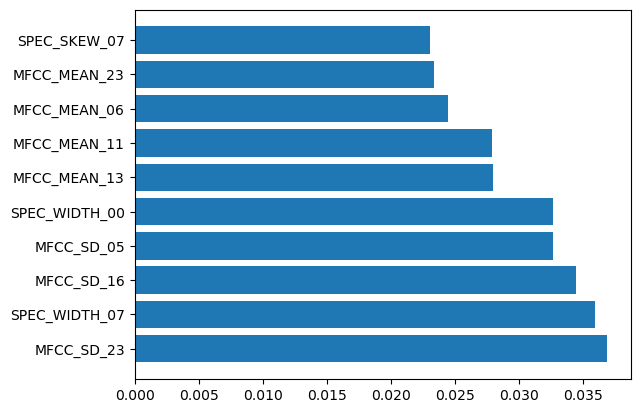

In [22]:
### plot global feature importance as calculated by xgboost
xgb_importance = xgb_class.feature_importances_
sorted_indices = np.flip(xgb_importance.argsort())
xgb_importance = xgb_importance[sorted_indices]
importance_labels = np.array(train_features)[sorted_indices]
plt.barh(importance_labels[0:10], xgb_importance[0:10])


### accuracy and valuation metrics calculated on the training sample
xgb_acc, xgb_precision, xgb_recall , xgb_cm = score_eval(y_train_enc, xgb_train, "XGBoost TRAIN", ylabels=y_enc_labels)

print("\n\nConfusion matrix - in-sample training dataset:")
print(xgb_cm)

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
n_folds = 5
accuracies = cross_val_score(estimator = xgb_model, X = X_train, y = y_train_enc, cv = n_folds)
print("\n\nEvaluating XGBoost model using training set and {}-fold cross validation: \nAverage Accuracy {:.3f} +/- {:.3f}".format(n_folds,accuracies.mean(), accuracies.std() ) )
print("Fold accuracies: {}\n\n".format(accuracies))


### extract loss values for both training and test datasets asa function of iteration (i.e., estimator added to the BDT)
xgb_train_results = xgb_model.evals_result()
xgb_train_loss = xgb_train_results['validation_0']['mlogloss']
xgb_test_loss  = xgb_train_results['validation_1']['mlogloss']
iters = len(xgb_train_loss)
x_iters = list(range(0, iters))

line_data = [ply_go.Scatter(x=x_iters, 
                            y=xgb_train_loss,
                            name="TRAIN"),
             ply_go.Scatter(x=x_iters, 
                            y=xgb_test_loss,
                            name="TEST")]
fig = ply_go.Figure(data=line_data)
fig.update_layout(title={'text': "Evaluation Log-Loss of XGBoost classifier"}, 
                  xaxis={"title":{"text":"Iteration"}}, yaxis={"title":{"text":"Multiclass Log-Loss"}})
fig.show()

In [23]:

print("\n\n\nVALIDATION USING TEST SAMPLE:")
xgb_acc, xgb_precision, xgb_recall , xgb_cm = score_eval(y_test_enc, xgb_test, "XGBoost", ylabels=y_enc_labels)

print("\n\nConfusion matrix:")
print(xgb_cm)





VALIDATION USING TEST SAMPLE:
XGBoost accuracy / precision / recall: 0.583 / 0.577 / 0.583



              precision    recall  f1-score   support

    COVID-19       0.62      0.67      0.64        12
     healthy       0.50      0.42      0.45        12
 symptomatic       0.62      0.67      0.64        12

    accuracy                           0.58        36
   macro avg       0.58      0.58      0.58        36
weighted avg       0.58      0.58      0.58        36



Confusion matrix:
[[8 3 1]
 [3 5 4]
 [2 2 8]]


### merge predictions back to original dataframe

After merging, select and print entries where the XGBoost does a bad job (logit regression is right but XGBoost is wrong)

In [24]:
logit_test_dec = labenc.inverse_transform(logit_test)
xgb_test_dec = labenc.inverse_transform(xgb_test)
logit_data = pd.DataFrame({'UUID':uuid_test, 'LOGIT_STATUS':logit_test_dec})
xgb_data = pd.DataFrame({'UUID':uuid_test, 'XGB_STATUS':xgb_test_dec})
pred_data = pd.merge(sampled_data, logit_data,on='UUID', how='left')
pred_data = pd.merge(pred_data, xgb_data,on='UUID', how='left')
pred_data.loc[(pred_data['STATUS']==pred_data['LOGIT_STATUS']) & (pred_data['STATUS']!=pred_data['XGB_STATUS']) &(~pd.isnull(pred_data['XGB_STATUS'])),]

,UUID,AUDIO_CLASS,COUGH_DETECTED,SNR,AGE,GENDER,RESPIRATORY_CONDITION,FEVER_MUSCLE_PAIN,STATUS,MFCC_MEAN_00,MFCC_MEAN_01,MFCC_MEAN_02,MFCC_MEAN_03,MFCC_MEAN_04,MFCC_MEAN_05,MFCC_MEAN_06,MFCC_MEAN_07,MFCC_MEAN_08,MFCC_MEAN_09,MFCC_MEAN_10,MFCC_MEAN_11,MFCC_MEAN_12,MFCC_MEAN_13,MFCC_MEAN_14,MFCC_MEAN_15,MFCC_MEAN_16,MFCC_MEAN_17,MFCC_MEAN_18,MFCC_MEAN_19,MFCC_MEAN_20,MFCC_MEAN_21,MFCC_MEAN_22,MFCC_MEAN_23,MFCC_MEAN_24,MFCC_MEAN_25,MFCC_SD_00,MFCC_SD_01,MFCC_SD_02,MFCC_SD_03,MFCC_SD_04,MFCC_SD_05,MFCC_SD_06,MFCC_SD_07,MFCC_SD_08,MFCC_SD_09,MFCC_SD_10,MFCC_SD_11,MFCC_SD_12,MFCC_SD_13,MFCC_SD_14,MFCC_SD_15,MFCC_SD_16,MFCC_SD_17,MFCC_SD_18,MFCC_SD_19,MFCC_SD_20,MFCC_SD_21,MFCC_SD_22,MFCC_SD_23,MFCC_SD_24,MFCC_SD_25,SPEC_CENTROID_00,SPEC_CENTROID_01,SPEC_CENTROID_02,SPEC_CENTROID_03,SPEC_CENTROID_04,SPEC_CENTROID_05,SPEC_CENTROID_06,SPEC_CENTROID_07,SPEC_WIDTH_00,SPEC_WIDTH_01,SPEC_WIDTH_02,SPEC_WIDTH_03,SPEC_WIDTH_04,SPEC_WIDTH_05,SPEC_WIDTH_06,SPEC_WIDTH_07,SPEC_CREST_00,SPEC_CREST_01,SPEC_CREST_02,SPEC_CREST_03,SPEC_CREST_04,SPEC_CREST_05,SPEC_CREST_06,SPEC_CREST_07,SPEC_MEAN_00,SPEC_MEAN_01,SPEC_MEAN_02,SPEC_MEAN_03,SPEC_MEAN_04,SPEC_MEAN_05,SPEC_MEAN_06,SPEC_MEAN_07,SPEC_SD_00,SPEC_SD_01,SPEC_SD_02,SPEC_SD_03,SPEC_SD_04,SPEC_SD_05,SPEC_SD_06,SPEC_SD_07,SPEC_SKEW_00,SPEC_SKEW_01,SPEC_SKEW_02,SPEC_SKEW_03,SPEC_SKEW_04,SPEC_SKEW_05,SPEC_SKEW_06,SPEC_SKEW_07,ZCR,SAMPLING_RATE,DURATION,MEAN_SIG,MAX_SIG,MIN_SIG,LOGIT_STATUS,XGB_STATUS
7,e65eb75f-ca15-4027-a0d7-2fea5f957521,A,0.8947,13.100575,73.0,male,False,False,healthy,-515.812112,13.781735,-6.753342,4.771154,-4.770725,0.766158,-1.409112,-5.108746,-6.563210,-2.001157,-4.150805,-0.629726,-3.944044,-5.326639,-4.581206,-2.209043,-2.342630,0.616313,-2.592368,1.339340,-1.182053,1.727651,-0.309199,3.748028,-1.000983,2.393138,186.180328,30.465633,23.739202,11.542018,13.434328,15.627349,11.150319,16.496874,12.317429,12.148898,10.321590,5.202422,8.967190,13.017601,10.818089,7.407449,7.548993,6.299250,6.732329,5.829127,4.864797,5.776525,6.200227,7.235954,3.837194,5.862173,152.354433,364.583529,558.409999,1037.498743,1604.875037,2348.937766,2904.548400,3842.665298,2052.168452,1623.983619,1448.423529,2576.032735,13090.449640,631.134268,605.070244,659.934993,2.624851,1.060790,1.450161,0.986229,1.391288,0.548469,0.702499,0.428672,0.004503,0.002214,0.003328,0.002147,0.001989,0.001934,0.000862,0.001132,0.004885,0.000672,0.001452,0.000735,0.000476,0.000448,0.000196,0.000245,61.525021,7.378962,8.876275,-1.097053,34.451613,-16.245531,-0.519685,-15.698682,0.035400,8192,9.900024,-0.000021,0.637783,-0.812074,healthy,COVID-19
26,f1563159-1350-4e0d-a007-ddc91504489e,A,0.9874,11.731203,71.0,female,False,False,healthy,-445.814125,22.067157,-7.624962,-4.854103,-5.269111,1.784386,-4.107199,-1.110311,-6.911079,-5.065410,-5.281521,-5.958855,-5.785454,-3.032418,-5.109606,-0.802153,-2.223233,-1.784782,-4.671263,-1.114636,-3.897895,0.509005,-2.587981,0.592118,-1.576697,1.647126,215.879738,33.996246,23.406713,15.455300,15.345848,9.703360,14.246185,11.005124,9.942960,8.396208,12.852092,11.610371,8.364815,7.953757,7.652496,5.622243,6.973563,9.826866,7.465385,6.734052,9.149245,6.009430,7.582516,7.228400,7.326365,4.636262,123.242451,351.666636,590.120482,1041.968069,1625.077271,2345.055770,2906.755291,3840.262090,2238.304533,1287.997387,1558.500851,3151.894056,13816.267516,762.513058,728.655131,656.827241,0.274630,1.050342,1.125091,2.159047,1.103353,0.215694,0.374399,0.485166,0.007343,0.008270,0.010762,0.006525,0.003409,0.002131,0.003481,0.003137,0.003759,0.001890,0.003757,0.000864,0.001129,0.000192,0.000392,0.000914,-29.421668,3.839160,9.406526,52.757533,44.915124,-19.169834,-7.809953,-5.762556,0.131079,8192,7.989380,-0.000005,0.949923,-0.935119,healthy,COVID-19
38,25b4902b-3a28-4392-ae54-e97915720546,A,0.9586,23.664680,61.0,male,False,False,healthy,-358.026378,67.207939,4.135403,-2.917221,-19.229477,-5.382957,-16.719786,-9.880908,-10.293378,-7.000856,-4.059730,-5.765477,-4.649925,-2.192750,-7.491085,-1.026714,-2.45372